In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("avito_train.tsv",sep='\t')

In [3]:
print df.shape, df.is_blocked.mean()
df[:5]

(3995803, 13) 0.0688212106553


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000025,Услуги,Предложения услуг,Монтаж кровли,Выполняем монтаж кровли фальцевой ^p Тел:8@@P...,"{""Вид услуги"":""Ремонт, строительство""}",0,NaN,0,1,0,0,22.38
2,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
3,10000101,Транспорт,Автомобили с пробегом,"Ford Focus, 2011","Автомобиль в отличном техническом состоянии, в...","{""Марка"":""Ford"", ""Модель"":""Focus"", ""Год выпуск...",365000,NaN,0,0,0,0,8.87
4,10000132,Транспорт,Запчасти и аксессуары,Турбина 3.0 Bar,Продам турбину на двигатель V-6 . V-8 и мощнее...,"{""Вид товара"":""Запчасти"", ""Тип товара"":""Для ав...",5000,NaN,0,0,0,0,11.82


In [4]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio 0.0688212106553
Count: 3995803


In [5]:
df[df.is_blocked == 1].shape

(274996, 13)

### Балансируем выборку рандомным downsample-ом негативных объектов.

In [6]:
#downsample
df = df[df.is_blocked == 1].append(df[df.is_blocked == 0].sample(300000, random_state=42))
df.sort_values('itemid', inplace=True)

print "Blocked ratio:",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio: 0.47825724005
Count: 574996


### Токенизируем заголовки и описания, одновременно заменяя все слова на их нормальные формы при помощи pymorphy2.

In [7]:
from nltk.tokenize import RegexpTokenizer
import pymorphy2

tokenizer = RegexpTokenizer(r"\w+")
morph = pymorphy2.MorphAnalyzer()

In [8]:
%%time
# Нормализацию можно распараллелить, но не было критично
def normalize(s):
    if type(s) is float:
        return s
    return ' '.join([morph.parse(t)[0].normal_form for t in tokenizer.tokenize(unicode(s.decode('utf-8')))])

df.loc[:,'description'] = df.description.apply(normalize)
df.loc[:,'title'] = df.title.apply(normalize)

CPU times: user 1h 14min 57s, sys: 16.7 s, total: 1h 15min 13s
Wall time: 1h 14min 47s


### Составляем словарь токенов, присваиваем им id-шники

In [9]:
from collections import Counter,defaultdict

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not unicode:
        continue
#     s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

### Удаляем слишком редкие токены

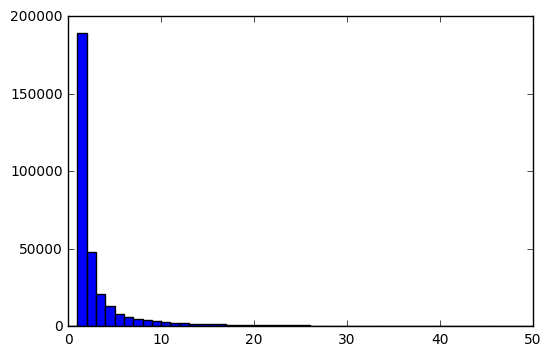

In [10]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [25]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.
min_count = 20
tokens = [token for token, count in token_counts.iteritems() if count >= min_count]

В финальном решении использовалось значение min_count=10, кол-во токенов получалось около 50к

In [26]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [27]:
print "# Tokens:",len(token_to_id)

# Tokens: 33594


### Заменяем тексты на вектора id-шников фиксированной размерности, используя 0-padding.

In [28]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not unicode:
            token_matrix.append([0]*max_len)
            continue
#         s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [29]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

Пример

In [30]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (574996, 15)
дизайн интерьер комплексный отделка -> [32534  9764   987 22411     0     0     0     0     0     0] ...
поездка на таможня печать в паспорт -> [ 8737 11283  8695 17992 27710  9031     0     0     0     0] ...
комната 13 м² в 2 к 5 5 эт -> [19997 30811 19575 27710  2406 23197 16380 16380 10072     0] ...


### Обработка порядковых и категориальных признаков

In [31]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [32]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

categories = [{"category":category_name, "subcategory":subcategory_name}\
              for category_name, subcategory_name in data_cat_subcat]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [33]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

### Делим выборку на обучающую и валидационную

In [34]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')
#Non-sequences
df_non_text = df_non_text.values.astype('float32')

In [35]:
#Split into training and test set.
#Select test set items that have item_ids strictly above that of training set

TEST_SIZE = 0.1
split_value = int(df.shape[0] * (1. - TEST_SIZE))

title_tr, title_ts = title_tokens[:split_value], title_tokens[split_value:]
desc_tr, desc_ts = desc_tokens[:split_value], desc_tokens[split_value:]
nontext_tr, nontext_ts = df_non_text[:split_value], df_non_text[split_value:]
target_tr, target_ts = target[:split_value], target[split_value:]

Show that classes balance maintains

In [36]:
target_tr.mean(), target_ts.mean()

(0.47803461282792525, 0.48026086956521741)

### Сохраняем предобработанные данные

In [1]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    data_tuple = title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts
    with open("preprocessed_data_norm_min20.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id_norm_min20.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data_norm_min10.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id_norm_min10.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print "done"        

Reading saved data...
done


### Обучаем сеть

In [2]:
#libraries
import lasagne
from theano import tensor as T
import theano

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5005)


In [3]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

In [4]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [5]:
N_EMBED = 256
N_HIDDEN_DESCR = 256
N_HIDDEN_TITLE = 256
GRAD_CLIP = 100
N_DENSE_CAT = 64

# Descriptions
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=N_EMBED)
descr_nn = lasagne.layers.LSTMLayer(descr_nn, N_HIDDEN_DESCR, grad_clipping=GRAD_CLIP, 
                                    nonlinearity=lasagne.nonlinearities.tanh, only_return_final=True)

# Titles
title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=N_EMBED)
title_nn = lasagne.layers.LSTMLayer(title_nn, N_HIDDEN_TITLE, grad_clipping=GRAD_CLIP, 
                                    nonlinearity=lasagne.nonlinearities.tanh, only_return_final=True)

# Non-sequences
cat_nn = lasagne.layers.DenseLayer(cat_inp, N_DENSE_CAT)

In [7]:
N_DENSE = 256
P_DROPOUT = 0.5

nn = lasagne.layers.ConcatLayer([descr_nn, title_nn, cat_nn])

nn = lasagne.layers.DenseLayer(nn, N_DENSE)
nn = lasagne.layers.DropoutLayer(nn, p=P_DROPOUT)
nn = lasagne.layers.DenseLayer(nn, 1, nonlinearity=lasagne.nonlinearities.linear)

In [8]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [9]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

DELTA = 1.
#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta = DELTA).mean()

In [10]:
#Weight optimization step
LR = 0.001
updates = lasagne.updates.adam(loss, weights, learning_rate=LR)

In [11]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction,target_y,delta = DELTA).mean()

In [12]:
%%time
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

CPU times: user 18.5 s, sys: 288 ms, total: 18.7 s
Wall time: 20.2 s


In [13]:
#average precision at K
from oracle import APatK, score

In [14]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)
def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100

for i in range(n_epochs):
    print "Epoch: {}".format(i)
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

Epoch: 0
Train:
	loss: 9978.11415355
	acc: 0.623861386139
	auc: 0.656580392665
	ap@k: 0.0389121582806
Val:
	loss: 3298.10400504
	acc: 0.557722772277
	auc: 0.567579572165
	ap@k: 0.479663165654
Epoch: 1
Train:
	loss: 3693.60662268
	acc: 0.673564356436
	auc: 0.702795028716
	ap@k: 0.0651140921868
Val:
	loss: 1886.47200105
	acc: 0.710792079208
	auc: 0.68720931009
	ap@k: 0.837130445955
Epoch: 2
Train:
	loss: 5541.93536943
	acc: 0.714554455446
	auc: 0.738042712648
	ap@k: 0.035607828999
Val:
	loss: 4504.06496233
	acc: 0.612079207921
	auc: 0.644785265935
	ap@k: 0.796911256178
Epoch: 3
Train:
	loss: 2965.18614598
	acc: 0.676732673267
	auc: 0.70298491787
	ap@k: 0.0921708543678
Val:
	loss: 6617.08863805
	acc: 0.596435643564
	auc: 0.582960238375
	ap@k: 0.870612513649
Epoch: 4
Train:
	loss: 2212.75352871
	acc: 0.688613861386
	auc: 0.726946369096
	ap@k: 0.0697623838052
Val:
	loss: 6869.69722099
	acc: 0.600396039604
	auc: 0.626036987817
	ap@k: 0.768867047641
Epoch: 5
Train:
	loss: 4818.48453586
	acc: 

### Тестируем сеть

In [17]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.124100072199
	acc: 0.952295652174
	auc: 0.986636586364
	ap@k: 0.99327600209

AUC:
	Отличное решение! (good)

Accuracy:
	Отличный результат! (good)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.


### Main task

* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92